<h1>What's for dinenr?</h1>
<h4><i> An simple LSTM model generates dinner suggestions from partial ingredient list </i><h4>
<h4><br></h4>
<h2>Introduction</h2>


<h2>Data Cleaning</h2>

In [113]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer

import seaborn as sns
from wordcloud import WordCloud

In [114]:
'''
def string_to_list(s):
    Converts a string that is formatted like a list to a list
    l = re.findall(r'\w[\w\s]+',s)
    #l = ' '.join(l)
    return l
'''

"\ndef string_to_list(s):\n    Converts a string that is formatted like a list to a list\n    l = re.findall(r'\\w[\\w\\s]+',s)\n    #l = ' '.join(l)\n    return l\n"

In [115]:
'''
#cleaning token lists
input_sequences = raw_recipes['ingredients'].apply(string_to_list).to_list()
input_sequences[:1]
'''

"\n#cleaning token lists\ninput_sequences = raw_recipes['ingredients'].apply(string_to_list).to_list()\ninput_sequences[:1]\n"

In [116]:
class clean_recipes():
    def __init__(self): 
        self.raw_recipes = self.import_data()
        self.input_sequences = self.raw_recipes['ingredients'].apply(self.string_to_list).to_list()

    def __call__(self):
        return self.raw_recipes, self.input_sequences

    def import_data(self):
        #'''Import cleaned recipe, raw recipe and ratings data'''
        raw_recipes = pd.read_csv('RAW_recipes.csv')
        del raw_recipes['contributor_id']
        del raw_recipes['submitted']
        del raw_recipes['tags']
        del raw_recipes['steps']
        del raw_recipes['description']
        raw_recipes = raw_recipes.set_index('id')
        return raw_recipes

    def string_to_list(self,s):
        '''Converts a string that is formatted like a list to a list'''
        l = re.findall(r'\w[\w\s]+',s)
        return l

In [117]:
raw_recipes, input_sequences = clean_recipes()()
raw_recipes.head()

,name,minutes,nutrition,n_steps,ingredients,n_ingredients
id,,,,,,
137739,arriba baked winter squash mexican style,55,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['winter squash', 'mexican seasoning', 'mixed ...",7
31490,a bit different breakfast pizza,30,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['prepared pizza crust', 'sausage patty', 'egg...",6
112140,all in the kitchen chili,130,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['ground beef', 'yellow onions', 'diced tomato...",13
59389,alouette potatoes,45,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,"['spreadable cheese with garlic and herbs', 'n...",11
44061,amish tomato ketchup for canning,190,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [118]:
input_sequences[:2]

[['winter squash',
  'mexican seasoning',
  'mixed spice',
  'honey',
  'butter',
  'olive oil',
  'salt'],
 ['prepared pizza crust',
  'sausage patty',
  'eggs',
  'milk',
  'salt and pepper',
  'cheese']]

<h2><br></h2>
<h2>EDA</h2>

Text(0.5, 1.0, 'Ingredients per recipe')

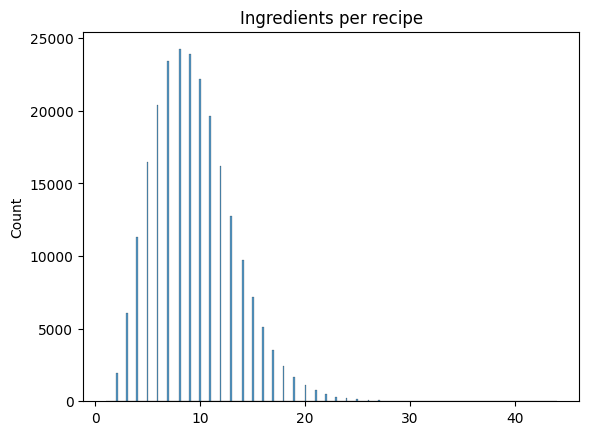

In [119]:
#ingredient list length distribution
lengths = [len(x) for x in input_sequences]
sns.histplot(lengths)
plt.title('Ingredients per recipe')

Text(0.5, 1.0, 'Word frequencies')

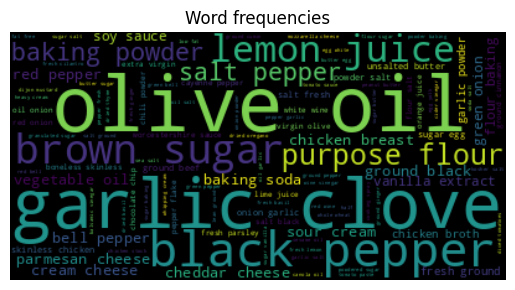

In [120]:
#overview of frequencies
all_words = ' '.join([x for sublist in input_sequences for x in sublist])
wordcloud = WordCloud().generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word frequencies')

In [121]:
#top words
def get_top(input_sequences):
    ingred = [x for sublist in input_sequences for x in sublist]
    ingred_counts = Counter(ingred).most_common()
    #top_ingredients = [ingred_counts[n][0] for n in range(len(ingred_counts))]
    return ingred_counts

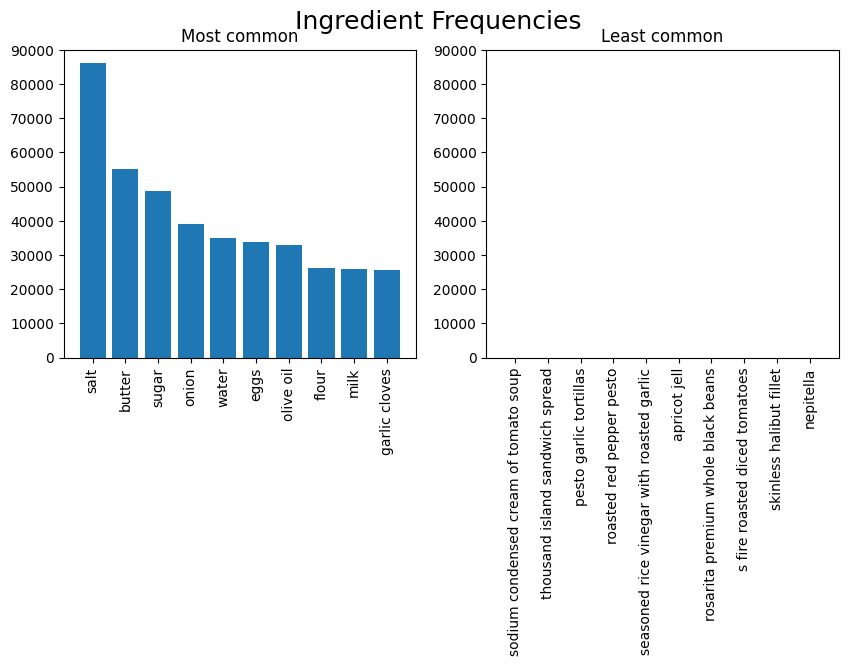

In [122]:
tops = get_top(input_sequences)
sorted_ingredients = [x[0] for x in tops]
sorted_counts = [x[1] for x in tops]

count_range = 10 
plt.figure(figsize=(10,4))
plt.suptitle('Ingredient Frequencies',fontsize=18)
plt.subplot(1,2,1)
plt.bar(sorted_ingredients[:count_range], sorted_counts[:count_range])
plt.xticks(rotation=90)
plt.ylim((0,90_000))
plt.title('Most common')

plt.subplot(1,2,2)
plt.bar(sorted_ingredients[-count_range:], sorted_counts[-count_range:])
plt.xticks(rotation=90)
plt.ylim((0,90_000))
plt.title('Least common');

<h2><br></h2>
<h2>Tokenizing ingredients</h2>

In [123]:
class TokenizeRecipes():
    def __init__(self, input_sequences):
        self.tokenizer = Tokenizer()
        self.input_sequences = input_sequences
    
    def __call__(self):
        self.tokenizer, self.ngram_sequences, self.totalwords = self.get_sequence_of_tokens()
        self.max_length = self.find_max()
        self.padded_sequence = self.pad_sequences()
        self.padded_sequence = np.array(self.padded_sequence)
        self.predictors, self.label = self.padded_sequence[:,:-1],self.padded_sequence[:,-1]
        return self.tokenizer, self.padded_sequence, self.totalwords, self.label, self.predictors

    def get_sequence_of_tokens(self):
        '''Tokenization'''    
        self.tokenizer.fit_on_texts(self.input_sequences)
        self.total_words = len(self.tokenizer.word_index) + 1

        self.ngram_sequences = []
        for line in self.input_sequences:
            token_list = self.tokenizer.texts_to_sequences([line])[0]
            for i in range(1, len(token_list)):
                n_gram_sequence = token_list[:i+1]
                self.ngram_sequences.append(n_gram_sequence)
        return self.tokenizer, self.ngram_sequences, self.total_words

    def find_max(self):
        '''find max token length'''
        self.max_length = max(len(x) for x in self.input_sequences)
        return self.max_length

    def pad_sequences(self):
        '''pad sequences (built in function returns a recursion error)'''
        self.padded_sequence = []
        for sequence_in in self.ngram_sequences:
            zeros = (self.max_length-len(sequence_in))
            padded = [int(0) for zero in range(zeros)]
            padded.extend(sequence_in)
            self.padded_sequence.append(padded)
        return self.padded_sequence

In [124]:
tokenizer,input_sequences,total_words,label,predictors = TokenizeRecipes(input_sequences)()
total_words

14991

In [125]:
np.array(input_sequences[:2])

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0, 2478, 3836],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0, 2478, 3836, 1060]])

In [127]:
label

array([3836, 1060,   30, ...,  312,   21,   29])

In [128]:
predictors

array([[   0,    0,    0, ...,    0,    0, 2478],
       [   0,    0,    0, ...,    0, 2478, 3836],
       [   0,    0,    0, ..., 2478, 3836, 1060],
       ...,
       [   0,    0,    0, ...,  135,    6,    8],
       [   0,    0,    0, ...,    6,    8,  312],
       [   0,    0,    0, ...,    8,  312,   21]])

In [ ]:
'''
tokenizer = Tokenizer()
def get_sequence_of_tokens(input_sequences):
    '''Tokenization'''    #raw recipe info
    tokenizer.fit_on_texts(input_sequences)
    total_words = len(tokenizer.word_index) + 1

    ngram_sequences = []
    for line in input_sequences:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            ngram_sequences.append(n_gram_sequence)
    return tokenizer, ngram_sequences, total_words
    '''

In [55]:
'''
input_sequences,total_words = get_sequence_of_tokens(input_sequences)
input_sequences[:6]
'''

'\ninput_sequences,total_words = get_sequence_of_tokens(input_sequences)\ninput_sequences[:6]\n'

In [ ]:
'''
def find_max(sequences):
    '''find max token length'''
    max_length = max(len(x) for x in sequences)
    return max_length

max_length = find_max(input_sequences)
max_length
'''

44

In [109]:
'''
def pad_sequences(sequence):
    #pad sequences (built in function returns a recursion error)
    padded_sequence = []
    for sequence_in in sequence:
        zeros = (max_length-len(sequence_in))
        padded = [int(0) for zero in range(zeros)]
        padded.extend(sequence_in)
        padded_sequence.append(padded)
    return padded_sequence

input_sequences = pad_sequences(input_sequences)
'''

'\ndef pad_sequences(sequence):\n    #pad sequences (built in function returns a recursion error)\n    padded_sequence = []\n    for sequence_in in sequence:\n        zeros = (max_length-len(sequence_in))\n        padded = [int(0) for zero in range(zeros)]\n        padded.extend(sequence_in)\n        padded_sequence.append(padded)\n    return padded_sequence\n\ninput_sequences = pad_sequences(input_sequences)\n'

In [ ]:
#making test and train sets 
'''
input_sequences = np.array(input_sequences)
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
'''

<h2><br></h2>
<h2>Genrating ingredient list</h2>

In [ ]:
def create_model(max_length, max_token):
    '''Build LSTM model'''
    input_len = max_length -1
    model = Sequential()
    model.add(Embedding(max_token, 10, input_length=input_len))
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    model.add(Dense(max_token, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    return model

In [ ]:
model = create_model(max_length, total_words)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 43, 10)            149910    
                                                                 
 lstm_8 (LSTM)               (None, 100)               44400     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 14991)             1514091   
                                                                 
Total params: 1708401 (6.52 MB)
Trainable params: 1708401 (6.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
test_size = None
history = model.fit(predictors[:test_size], label[:test_size], epochs=4)

Epoch 1/4
60886/60886 [==============================] - 1337s 22ms/step - loss: 5.5912
Epoch 2/4
60886/60886 [==============================] - 1577s 26ms/step - loss: 5.2051
Epoch 3/4
60886/60886 [==============================] - 1627s 27ms/step - loss: 5.1306
Epoch 4/4
60886/60886 [==============================] - 1654s 27ms/step - loss: 5.1055


generating text

In [ ]:
def cook_for_me(seed_text, model):
    next_words = 5
    words_out = []
    while next_words > 0:
        token_list = tokenizer.texts_to_sequences([seed_text])[0]      
        token_list = pad_sequences([token_list])
        token_list = np.array(token_list)
        token_list = token_list[:,1:]
        proba = model.predict(token_list, verbose=0)
        predicted = np.argmax(proba, axis=1)
        word = list(tokenizer.word_index.keys())[int(predicted-1)]
        words_out.append(word)
        next_words -= 1
        seed_text = seed_text + ' ' + word
    words_out = list(set(words_out))
    string_out = 'Why not try adding some '+', '.join(words_out[:-1])+' and '+words_out[-1]+'?'
    return string_out

In [ ]:
def make_suggestions(ingredients_in_stock):
    for ingredient in ingredients_in_stock:
        split_ingredients = ' and '.join(ingredient.split(' '))
        greeting = 'For '+split_ingredients.upper() +' let me see... '
        print(greeting)
        print(cook_for_me(ingredient,model))
        print('')

In [ ]:
ingredients_in_stock = ['chicken','chicken rice','tuna','chocolate sugar','pineapple']
make_suggestions(ingredients_in_stock)

For CHICKEN let me see... 


Why not try adding some onion, garlic cloves, salt, butter and pepper?

For CHICKEN AND RICE let me see... 
Why not try adding some onion, garlic cloves, salt, water and pepper?

For TUNA let me see... 
Why not try adding some onion, sour cream, mayonnaise, celery and style corn?

For CHOCOLATE AND SUGAR let me see... 
Why not try adding some baking powder, flour, vanilla extract, butter and eggs?

For PINEAPPLE let me see... 
Why not try adding some sugar, lemon juice and water?



: 